## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import time
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose

In [0]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [0]:
print('monotonic:', data.index.is_monotonic)
print()
print(data.info())

monotonic: True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Датасет состоит из одного столбца. В столбце 'num_orders' (от англ. number of orders, «число заказов») находится количество заказов. Данные представлены с 01.03.2018 по 31.08.2018. Даты расположены в хронологическом порядке.

Согласно заданию произведем ресемплирование по одному часу:

In [0]:
data = data.resample('1H').sum()

# 2. Анализ

In [0]:
data_analys = data.copy()

Построим график временного ряда:

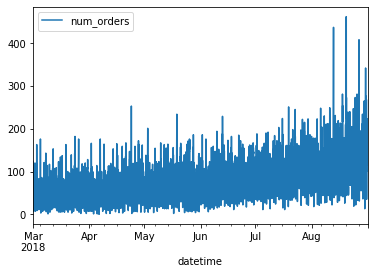

In [0]:
data_analys.plot()

График неинформативен. Построим график с ресемплированием по одному дню:

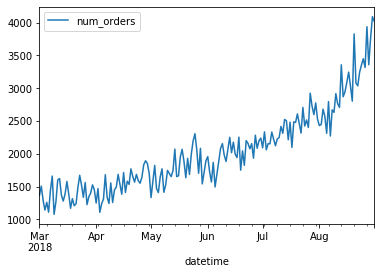

In [0]:
data_analys.resample('1D').sum().plot()

График приобрел более "читаемый" вид. Видно тренд на повышение количества заказов (это утверждение проверим специальными функциями дальше). 

Посмотрим на график с ресемплированием по одной неделе:

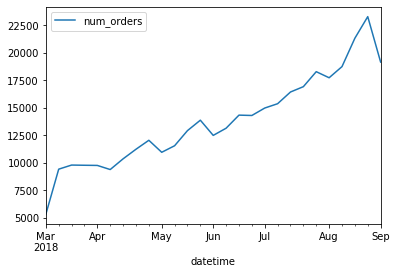

In [0]:
data_analys.resample('1W').sum().plot()

На данном графике уже нет сильных скачков. Количество заказов в плавно повышается с марта по август.

Посмотрим на графики за один один: первого дня в датасете и последнего:

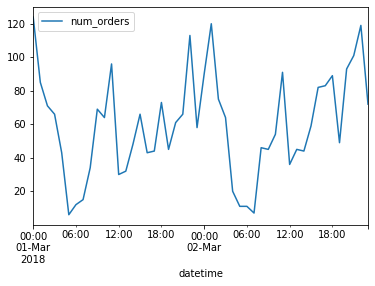

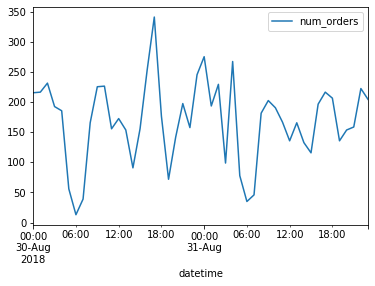

In [0]:
data_analys['2018-03-01':'2018-03-02'].plot(y = 'num_orders')
data_analys['2018-08-30':'2018-08-31'].plot(y = 'num_orders')

Графики в целом похожи. На обоих наблюдается минимальное количество заказов примерно в 6 часов утра и максимальное вечером, с 6 до 12. Это также проверим чуть ниже. В целом данные за эти дни похожи, только 31 августа заказов было больше, чем 1 марта. 

Посмотрим на скользящее среднее с окном в двое суток:

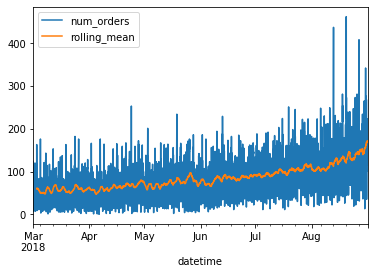

In [0]:
data_analys['rolling_mean'] = data_analys['num_orders'].shift().rolling(48).mean()
data_analys.plot()

Разложим временной ряд на тренд, сезонную компоненту и остатки. Построим графики: 

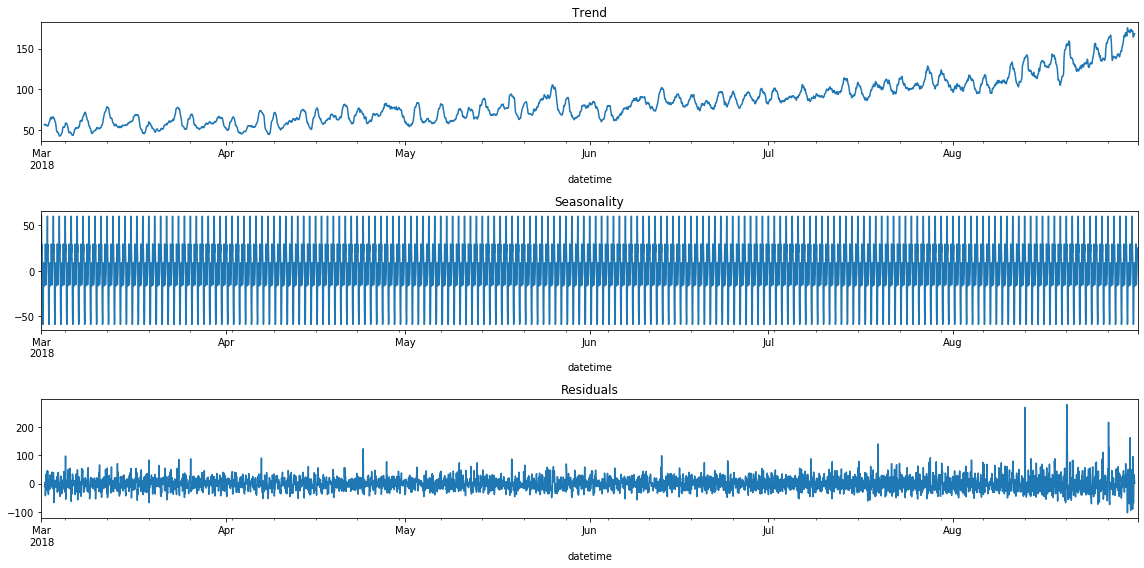

In [0]:
decomposed = seasonal_decompose(data_analys['num_orders'])

plt.figure(figsize=(16, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По первому графику видно тренд - количество заказов растет (еще бы, такое название :) ). Также видно, что сильный рост начался с июня, до этого график практически пологий. Есть явная сезонность (как мы уже знает, с периодом в день). 

Рассмотрим сезонную составляющую поближе. Возьем данные за три дня:

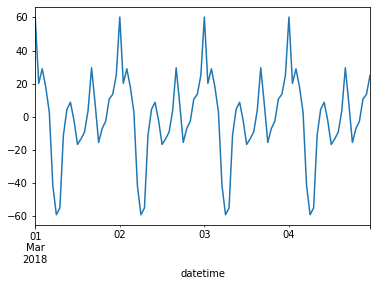

In [0]:
decomposed.seasonal['2018-03-01':'2018-03-04'].resample('1H').sum().plot()

Видим, что больше всего заказов около 12 часов ночи, а минимальное - в 6 утра.

Оценим стационарность ряда:

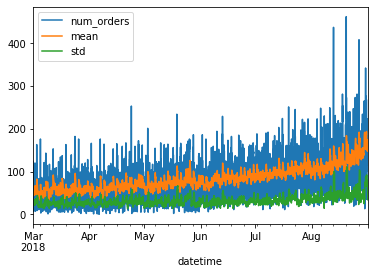

In [0]:
data1 = data.copy()
data1['mean'] = data1['num_orders'].rolling(15).mean()
data1['std'] = data1['num_orders'].rolling(15).std()
data1.plot()

Стандартное отклонение не меняется, а вот среднее к концу ряда растет. Ряд нестационарен.

# 3. Обучение

Получим значения RMSE константных моделей для оценки адекватности:

In [0]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

print("Среднее количество заказов в час:", test['num_orders'].mean())

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE константной модели (предыдущее значение):", mean_squared_error(test, pred_previous)**0.5)

pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE константной модели (среднее значение):", mean_squared_error(test['num_orders'], pred_mean)**0.5)

Среднее количество заказов в час: 139.55656108597285
RMSE константной модели (предыдущее значение): 58.856486242815066
RMSE константной модели (среднее значение): 84.74414402014742


Напишем функцию, генерирующую календарные признаки, "отстающие" значения и скользящее среднее:

In [0]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

Напишем фукнцию для упрощения разбиения датафрейма на обучающую, валидационную и тестовую выборки в отношении 8:1:1 :

In [0]:
def train_valid_test_split(data):
    
    train, temp = train_test_split(data, shuffle=False, test_size=0.2)
    valid, test = train_test_split(temp, shuffle=False, test_size=0.5)
    train = train.dropna()

    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']

    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid['num_orders']

    features_test = test.drop(['num_orders'], axis=1)
    target_test = test['num_orders']
    
    return features_train, target_train, features_valid, target_valid, features_test, target_test

Обучим несколько различных моделей, подберем гиперпараметры:

In [0]:
%%time
print('Линейная регрессия')

data_lr2 = data.copy()
data_lr2 = make_features(data_lr2, 200, 100)

features_train_lr2, target_train_lr2, features_valid_lr2, target_valid_lr2, features_test_lr2, target_test_lr2 = (
train_valid_test_split(data_lr2))

model_lr2 = LinearRegression()
model_lr2.fit(features_train_lr2, target_train_lr2)
predictions_train_lr2 = model_lr2.predict(features_train_lr2)
predictions_valid_lr2 = model_lr2.predict(features_valid_lr2)

print("RMSE обучающей выборки:", mean_squared_error(target_train_lr2, predictions_train_lr2)**0.5)
print("RMSE валидационной выборки: ", mean_squared_error(target_valid_lr2, predictions_valid_lr2)**0.5)

Линейная регрессия
RMSE обучающей выборки: 18.9629130065441
RMSE валидационной выборки:  28.216462898239563
CPU times: user 392 ms, sys: 280 ms, total: 672 ms
Wall time: 698 ms


Проверим правильность работы функции train_valid_test_split:

In [0]:
print('Обучающая:     с', features_train_lr2.index.min(), 'по', features_train_lr2.index.max())
print('Валидационная: с', features_valid_lr2.index.min(), 'по', features_valid_lr2.index.max())
print('Тестовая:      с', features_test_lr2.index.min(), 'по', features_test_lr2.index.max())

Обучающая:     с 2018-03-09 08:00:00 по 2018-07-26 03:00:00
Валидационная: с 2018-07-26 04:00:00 по 2018-08-13 13:00:00
Тестовая:      с 2018-08-13 14:00:00 по 2018-08-31 23:00:00


Функция работает правильно.

Обучим модель линейной регрессии с использованием стандартизации признаков:

In [0]:
%%time
print('Линейная регрессия (scaler)')

data_lr1 = data.copy()
data_lr1 = make_features(data_lr1, 200, 100)

features_train_lr1, target_train_lr1, features_valid_lr1, target_valid_lr1, features_test_lr1, target_test_lr1 = (
train_valid_test_split(data_lr1))

scaler_lr1 = StandardScaler()
scaler_lr1.fit(features_train_lr1)
features_train_lr1 = scaler_lr1.transform(features_train_lr1)
features_valid_lr1 = scaler_lr1.transform(features_valid_lr1)
features_test_lr1 = scaler_lr1.transform(features_test_lr1)

model_lr1 = LinearRegression()
model_lr1.fit(features_train_lr1, target_train_lr1)
predictions_train_lr1 = model_lr1.predict(features_train_lr1)
predictions_valid_lr1 = model_lr1.predict(features_valid_lr1)

print("RMSE обучающей выборки:", mean_squared_error(target_train_lr1, predictions_train_lr1)**0.5)
print("RMSE валидационной выборки: ", mean_squared_error(target_valid_lr1, predictions_valid_lr1)**0.5)

Линейная регрессия (scaler)
RMSE обучающей выборки: 18.962422595872322
RMSE валидационной выборки:  28.213974583557945
CPU times: user 456 ms, sys: 176 ms, total: 632 ms
Wall time: 676 ms


Стандартизация признаков уменьшения RMSE не вызывает, далее обучим модели без нее.

In [0]:
%%time
print('"Стандартный" LightGBM')

data_lgb2 = data.copy()
data_lgb2 = make_features(data_lgb2, 350, 100)

features_train_lgb2, target_train_lgb2, features_valid_lgb2, target_valid_lgb2, features_test_lgb2, target_test_lgb2 = (
train_valid_test_split(data_lgb2))

model_lgb2 = lgb.LGBMRegressor()
model_lgb2.fit(features_train_lgb2, target_train_lgb2)

pred_train_lgb2 = model_lgb2.predict(features_train_lgb2)
rmse_train_lgb2 = mean_squared_error(target_train_lgb2, pred_train_lgb2) ** 0.5
print('RMSE обучающей выборки:', rmse_train_lgb2)

pred_valid_lgb2 = model_lgb2.predict(features_valid_lgb2)
rmse_valid_lgb2 = mean_squared_error(target_valid_lgb2, pred_valid_lgb2) ** 0.5
print('RMSE валидационной выборки:', rmse_valid_lgb2)

"Стандартный" LightGBM
RMSE обучающей выборки: 6.5809010581866865
RMSE валидационной выборки: 28.646033872141548
CPU times: user 11.4 s, sys: 84 ms, total: 11.5 s
Wall time: 11.6 s


In [0]:
%%time
print('"Настроеный" LightGBM')

data_lgb = data.copy()
data_lgb = make_features(data_lgb, 350, 100)

features_train_lgb, target_train_lgb, features_valid_lgb, target_valid_lgb, features_test_lgb, target_test_lgb = (
train_valid_test_split(data_lgb))

lgb_train = lgb.Dataset(features_train_lgb, target_train_lgb)
lgb_eval = lgb.Dataset(features_valid_lgb, target_valid_lgb, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=5,
                verbose_eval=False)

pred_train_lgb = gbm.predict(features_train_lgb, num_iteration=gbm.best_iteration)
rmse_train_lgb = mean_squared_error(target_train_lgb, pred_train_lgb) ** 0.5
print('RMSE обучающей выборки:', rmse_train_lgb)

pred_valid_lgb = gbm.predict(features_valid_lgb, num_iteration=gbm.best_iteration)
rmse_valid_lgb = mean_squared_error(target_valid_lgb, pred_valid_lgb) ** 0.5
print('RMSE валидационной выборки:', rmse_valid_lgb)

"Настроеный" LightGBM
RMSE обучающей выборки: 10.330000542958283
RMSE валидационной выборки: 29.31666621073873
CPU times: user 13.9 s, sys: 84 ms, total: 14 s
Wall time: 14.2 s


In [0]:
%%time
print('CatBoost')

data_cat = data.copy()
data_cat = make_features(data_cat, 350, 100)

features_train_cat, target_train_cat, features_valid_cat, target_valid_cat, features_test_cat, target_test_cat = (
train_valid_test_split(data_cat))

model_cat = CatBoostRegressor(iterations=1000)
model_cat.fit(features_train_cat, target_train_cat, verbose=0)

pred_train_cat = model_cat.predict(features_train_cat)
rmse_train_cat = mean_squared_error(target_train_cat, pred_train_cat) ** 0.5
print('RMSE обучающей выборки:', rmse_train_cat)

pred_valid_cat = model_cat.predict(features_valid_cat)
rmse_valid_cat = mean_squared_error(target_valid_cat, pred_valid_cat) ** 0.5
print('RMSE валидационной выборки:', rmse_valid_cat)

CatBoost
RMSE обучающей выборки: 10.876836864658403
RMSE валидационной выборки: 29.15773881724798
CPU times: user 3min 11s, sys: 8.8 s, total: 3min 19s
Wall time: 3min 23s


Модели обучены, на валидационной выборке все они показывают схожие результаты RMSE: 28-29. Однако лучшие показатели у линейных регрессий. Также они обучаются быстрее всего. CatBoost значительно проигрывает остальным по времени обучения.

# 4. Тестирование

In [0]:
print('Линейная регрессия')
predictions_test_lr2 = model_lr2.predict(features_test_lr2)
print("RMSE тестовой выборки: ", mean_squared_error(target_test_lr2, predictions_test_lr2)**0.5)
print()
print('Линейная регрессия (scaler)')
predictions_test_lr1 = model_lr1.predict(features_test_lr1)
print("RMSE тестовой выборки: ", mean_squared_error(target_test_lr1, predictions_test_lr1)**0.5)
print()
print('"Стандартный" LightGBM')
predictions_test_lgb2 = model_lgb2.predict(features_test_lgb2)
print("RMSE тестовой выборки: ", mean_squared_error(target_test_lgb2, predictions_test_lgb2)**0.5)
print()
print('"Настроеный" LightGBM')
predictions_test_lgb = gbm.predict(features_test_lgb, num_iteration=gbm.best_iteration)
print("RMSE тестовой выборки: ", mean_squared_error(target_test_lgb, predictions_test_lgb)**0.5)
print()
print('CatBoost')
predictions_test_cat = model_cat.predict(features_test_cat)
print("RMSE тестовой выборки: ", mean_squared_error(target_test_cat, predictions_test_cat)**0.5)
print()

Линейная регрессия
RMSE тестовой выборки:  37.23694188670338

Линейная регрессия (scaler)
RMSE тестовой выборки:  37.22816063975103

"Стандартный" LightGBM
RMSE тестовой выборки:  43.85315227043459

"Настроеный" LightGBM
RMSE тестовой выборки:  43.6571225815021

CatBoost
RMSE тестовой выборки:  43.90734375102182



Модель                                   | RMSE | Время обучения
:--------------------------------------- | ---- | -------------
Константная модель (предыдущее значение) | 59   | -
Константная модель (среднее значение)    | 85   | -
Линейная регрессия                       | 37.2 | <1 сек
Линейная регрессия (scaler)              | 37.2 | <1 сек
"Стандартный" LightGBM                   | 43.9 | 12 сек
"Настроенный" LightGBM                   | 43.7 | 13 сек
CatBoost                                 | 44   | 3 мин 24 сек

 - Все модели показали результат лучше константных моделей.
 - Все модели обеспечили необходимое по заданию значение метрики RMSE < 48.
 - Линейные регрессии явные фавориты - при самом быстром обучении они показали лучший результат.
 - Бустинги показали практически одинаковые результаты. Однако CatBoost обучался значительно дольше других моделей.
 - "Стандартный" LightGBM переобучился на обучающей выборке и дал лучший результат на валидационной, чем "настроенный". Однако уже на тестовой выборке "настроенный" показал себя чуть лучше ввиду меньшего переобучения.